# Import and Reading of csv



In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from collections import Counter

In [2]:
# mosq_csv = pd.read_csv('MTM_DISCRIMINATING_CONCENTRATION_BIOASSAY_MOD.csv')

In [3]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
mosq_csv = pd.read_csv('/content/drive/MyDrive/CMP466 - Machine Learning/Project/MTM_DISCRIMINATING_CONCENTRATION_BIOASSAY_MOD.csv')

Mounted at /content/drive/


# Preprocessing

In [4]:
# Verify the class distribution
print("Class distribution before preprocessing:")
print(Counter(mosq_csv['RESISTANCE_STATUS']))

Class distribution before preprocessing:
Counter({'Confirmed resistance': 10112, 'Susceptible': 7568, 'Possible resistance': 2675, 'Undetermined': 719})


In [5]:
mosq_csv.nunique()

ID                       21074
COUNTRY_NAME                87
ISO2                        86
ADMIN1                     721
ADMIN2                    1913
SITE_NAME                 3782
SITE_CODE                 3793
LATITUDE                  3624
LONGITUDE                 3635
ASSAY_TYPE                   1
TEST_TYPE                    3
INSECTICIDE_CLASS            6
INSECTICIDE_TYPE            18
INSECTICIDE_CONC            18
INSECTICIDE_INTENSITY        1
YEAR_START                  44
SPECIES                     92
STAGE_ORIGIN                 5
MOSQUITO_NUMBER            431
TEST_TIME                    0
MORTALITY_ADJUSTED        1594
RESISTANCE_STATUS            4
DATA_SOURCE                264
CITATION                   660
CITATION_URL               447
DATA_CURATOR                 3
dtype: int64

In [6]:
labelsX = ['COUNTRY_NAME', 'INSECTICIDE_CLASS','ADMIN1','ADMIN2','SITE_NAME','TEST_TYPE','INSECTICIDE_TYPE','INSECTICIDE_CONC', 'MOSQUITO_NUMBER','SPECIES']

mosq_csv_ = mosq_csv[labelsX + ['RESISTANCE_STATUS']]
# mosq_csv_Y=mosq_csv['RESISTANCE_STATUS']

print(mosq_csv_.nunique())
# print(mosq_csv_Y.nunique())

COUNTRY_NAME           87
INSECTICIDE_CLASS       6
ADMIN1                721
ADMIN2               1913
SITE_NAME            3782
TEST_TYPE               3
INSECTICIDE_TYPE       18
INSECTICIDE_CONC       18
MOSQUITO_NUMBER       431
SPECIES                92
RESISTANCE_STATUS       4
dtype: int64


In [7]:
mosq_csv_ = mosq_csv_.replace(['', 'Not available', 'Undetermined'],np.NaN)

In [8]:
mosq_csv_.count()

COUNTRY_NAME         21074
INSECTICIDE_CLASS    21074
ADMIN1               21018
ADMIN2               21018
SITE_NAME            21074
TEST_TYPE            21074
INSECTICIDE_TYPE     21074
INSECTICIDE_CONC     21074
MOSQUITO_NUMBER      18620
SPECIES              21074
RESISTANCE_STATUS    20355
dtype: int64

In [9]:
mosq_csv_.isnull().sum()

COUNTRY_NAME            0
INSECTICIDE_CLASS       0
ADMIN1                 56
ADMIN2                 56
SITE_NAME               0
TEST_TYPE               0
INSECTICIDE_TYPE        0
INSECTICIDE_CONC        0
MOSQUITO_NUMBER      2454
SPECIES                 0
RESISTANCE_STATUS     719
dtype: int64

In [10]:
mosq_csv_ = mosq_csv_.dropna()
mosq_csv_.dtypes

COUNTRY_NAME         object
INSECTICIDE_CLASS    object
ADMIN1               object
ADMIN2               object
SITE_NAME            object
TEST_TYPE            object
INSECTICIDE_TYPE     object
INSECTICIDE_CONC     object
MOSQUITO_NUMBER      object
SPECIES              object
RESISTANCE_STATUS    object
dtype: object

In [11]:
mosq_csv_.count()

COUNTRY_NAME         17880
INSECTICIDE_CLASS    17880
ADMIN1               17880
ADMIN2               17880
SITE_NAME            17880
TEST_TYPE            17880
INSECTICIDE_TYPE     17880
INSECTICIDE_CONC     17880
MOSQUITO_NUMBER      17880
SPECIES              17880
RESISTANCE_STATUS    17880
dtype: int64

In [12]:
mosq_csv_.isnull().sum()

COUNTRY_NAME         0
INSECTICIDE_CLASS    0
ADMIN1               0
ADMIN2               0
SITE_NAME            0
TEST_TYPE            0
INSECTICIDE_TYPE     0
INSECTICIDE_CONC     0
MOSQUITO_NUMBER      0
SPECIES              0
RESISTANCE_STATUS    0
dtype: int64

In [13]:
# Verify the class distribution
print("Class distribution after preprocessing:")
print(Counter(mosq_csv_['RESISTANCE_STATUS']))

Class distribution after preprocessing:
Counter({'Confirmed resistance': 8918, 'Susceptible': 6649, 'Possible resistance': 2313})


# Creating two datasets: With ranges(took the median) and Without ranges(removed the ranges)

In [14]:
ranges_mosq = mosq_csv_.copy()

# Filter rows with ~100 and ranges
selected_rows = mosq_csv_[
    mosq_csv_['MOSQUITO_NUMBER'].str.startswith('~') | mosq_csv_['MOSQUITO_NUMBER'].str.contains('-')
]

# Process ~100 values and ranges
selected_rows['MOSQUITO_NUMBER'] = selected_rows['MOSQUITO_NUMBER'].str.replace('~', '')  # Remove ~ from ~100
selected_rows['MOSQUITO_NUMBER'] = selected_rows['MOSQUITO_NUMBER'].str.replace('-', ' ').astype(str)  # Replace '-' with ' '
selected_rows['MOSQUITO_NUMBER'] = selected_rows['MOSQUITO_NUMBER'].str.split().apply(lambda x: sum(map(float, x))/len(x))  # Calculate median for ranges

# Update the original DataFrame with the processed rows
ranges_mosq['MOSQUITO_NUMBER'].update(selected_rows['MOSQUITO_NUMBER'])

<ipython-input-14-abd3d9f74844>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_rows['MOSQUITO_NUMBER'] = selected_rows['MOSQUITO_NUMBER'].str.replace('~', '')  # Remove ~ from ~100
<ipython-input-14-abd3d9f74844>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_rows['MOSQUITO_NUMBER'] = selected_rows['MOSQUITO_NUMBER'].str.replace('-', ' ').astype(str)  # Replace '-' with ' '
<ipython-input-14-abd3d9f74844>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [15]:
print("\nDataframe with ranges:")
print(ranges_mosq['MOSQUITO_NUMBER'].tail(5))
print(ranges_mosq.count())


Dataframe with ranges:
21069    100
21070    100
21071     48
21072     40
21073     40
Name: MOSQUITO_NUMBER, dtype: object
COUNTRY_NAME         17880
INSECTICIDE_CLASS    17880
ADMIN1               17880
ADMIN2               17880
SITE_NAME            17880
TEST_TYPE            17880
INSECTICIDE_TYPE     17880
INSECTICIDE_CONC     17880
MOSQUITO_NUMBER      17880
SPECIES              17880
RESISTANCE_STATUS    17880
dtype: int64


In [16]:
# Check which rows contain 'µg' in the INSECTICIDE_CONC column
contains_microgram_r = ranges_mosq['INSECTICIDE_CONC'].str.contains('µg')

# Invert the boolean mask to select rows that do not contain 'µg'
rows_to_keep_r = ~contains_microgram_r

# Filter the DataFrame to keep only the rows without 'µg' in the INSECTICIDE_CONC column
ranges_mosq = ranges_mosq[rows_to_keep_r]

In [17]:
def convert_percentage_to_number(percentage):
    if pd.isna(percentage):  # Check if the value is NaN
        return None
    else:
        return float(percentage.strip('%')) / 100  # Convert percentage to number

# Apply the function to the 'INSECTICIDE_CONC' column
ranges_mosq['INSECTICIDE_CONC'] = ranges_mosq['INSECTICIDE_CONC'].apply(convert_percentage_to_number)

<ipython-input-17-88eabf249006>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ranges_mosq['INSECTICIDE_CONC'] = ranges_mosq['INSECTICIDE_CONC'].apply(convert_percentage_to_number)


In [18]:
print(ranges_mosq['INSECTICIDE_CONC'].head(20))

0     0.0010
2     0.0005
4     0.0005
8     0.0005
9     0.0400
11    0.0005
12    0.0010
13    0.0075
14    0.0075
15    0.0075
18    0.0400
20    0.0075
23    0.0400
24    0.0005
26    0.0050
27    0.0400
28    0.0100
29    0.0500
30    0.0400
31    0.0005
Name: INSECTICIDE_CONC, dtype: float64


In [19]:
ranges_mosq['MOSQUITO_NUMBER'] = ranges_mosq['MOSQUITO_NUMBER'].astype('float64')
ranges_mosq['INSECTICIDE_CONC'] = ranges_mosq['INSECTICIDE_CONC'].astype('float64')

In [20]:
ranges_mosq.dtypes

COUNTRY_NAME          object
INSECTICIDE_CLASS     object
ADMIN1                object
ADMIN2                object
SITE_NAME             object
TEST_TYPE             object
INSECTICIDE_TYPE      object
INSECTICIDE_CONC     float64
MOSQUITO_NUMBER      float64
SPECIES               object
RESISTANCE_STATUS     object
dtype: object

- Removing MORTALITY_ADJUSTED range values
- Removing NaNs and Not Availables
- Removing ug values from INSECTICIDE_CONC

MORTALITY_ADJUSTED RANGE TYPICALLY
1. 98 to 100 = Susceptible
2. 90 to 98 = Possible Resistance
3. Remaining is Confirmed Resistance

DATASET
- With ranges in MOSQUITO_NUMBER
- Without ranges in MOSQUITO_NUMBER

# Encoding & Oversampling

In [21]:
def encode_categorical_columns(df, columns):
    encoders = {}
    for column in columns:
        encoder = LabelEncoder()
        encoded_values = encoder.fit_transform(df[column])
        df[column] = encoded_values
        encoders[column] = encoder
    return df, encoders

In [22]:
columns_to_encode = ['RESISTANCE_STATUS','COUNTRY_NAME', 'INSECTICIDE_CLASS','ADMIN1','ADMIN2','SITE_NAME','INSECTICIDE_TYPE','SPECIES', 'TEST_TYPE']

ranges_mosq, encoders_r = encode_categorical_columns(ranges_mosq.copy(), columns_to_encode)

In [23]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
import pandas as pd

# Calculate the number of samples in class 0
class_0_count = len(ranges_mosq[ranges_mosq['RESISTANCE_STATUS'] == 0])

# Calculate the number of samples in class 2
class_2_count = len(ranges_mosq[ranges_mosq['RESISTANCE_STATUS'] == 2])

# Define the oversampling strategy for class 1
oversample_strategy = {1: class_2_count}

# Define the undersampling strategy for class 0
undersample_strategy = {0: class_2_count}

# Define the SMOTE object
oversampler = SMOTE(sampling_strategy=oversample_strategy)

# Define the RandomUnderSampler object
undersampler = RandomUnderSampler(sampling_strategy=undersample_strategy)

# Define the pipeline
pipeline = Pipeline([
    ('under', undersampler),
    ('over', oversampler),
])

# Apply the pipeline to the dataframe
X_resampled, y_resampled = pipeline.fit_resample(ranges_mosq.drop(columns=['RESISTANCE_STATUS']), ranges_mosq['RESISTANCE_STATUS'])

# Combine X_resampled and y_resampled into a new DataFrame
ranges_mosq = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled, columns=['RESISTANCE_STATUS'])], axis=1)

# Verify the class distribution
print("Class distribution after resampling:")
print(Counter(ranges_mosq['RESISTANCE_STATUS']))

Class distribution after resampling:
Counter({0: 6118, 1: 6118, 2: 6118})


# Seperating Values_mosq & Ranges_mosq into target and predictor dataframes

In [24]:
labelsX = ['COUNTRY_NAME', 'INSECTICIDE_CLASS','ADMIN1','ADMIN2','SITE_NAME','INSECTICIDE_TYPE','INSECTICIDE_CONC', 'MOSQUITO_NUMBER','SPECIES', 'TEST_TYPE']

ranges_mosq_X = ranges_mosq[labelsX]
ranges_mosq_Y=ranges_mosq['RESISTANCE_STATUS']

In [25]:
print(ranges_mosq_X.nunique())
print(ranges_mosq_Y.nunique())

COUNTRY_NAME           81
INSECTICIDE_CLASS       4
ADMIN1                651
ADMIN2               1680
SITE_NAME            3202
INSECTICIDE_TYPE       15
INSECTICIDE_CONC     2538
MOSQUITO_NUMBER      3319
SPECIES                86
TEST_TYPE               2
dtype: int64
3


In [26]:
ranges_mosq_X.describe()

,COUNTRY_NAME,INSECTICIDE_CLASS,ADMIN1,ADMIN2,SITE_NAME,INSECTICIDE_TYPE,INSECTICIDE_CONC,MOSQUITO_NUMBER,SPECIES,TEST_TYPE
count,18354.000000,18354.000000,18354.000000,18354.000000,18354.000000,18354.000000,18354.000000,18354.000000,18354.000000,18354.000000
mean,42.650104,2.122371,321.763376,857.740275,1593.711670,6.910047,0.011993,97.622969,31.103302,0.999891
std,23.546591,1.107553,178.322694,472.438298,917.802093,3.577664,0.017067,84.993629,21.207642,0.010438
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000500,11.000000,0.000000,0.000000
25%,26.000000,1.000000,170.000000,464.000000,804.250000,5.000000,0.000500,74.413975,14.000000,1.000000
50%,40.000000,3.000000,324.000000,833.500000,1571.000000,6.000000,0.001000,100.000000,29.000000,1.000000
75%,67.000000,3.000000,469.000000,1267.000000,2366.000000,10.000000,0.011206,100.000000,34.000000,1.000000
max,80.000000,3.000000,650.000000,1685.000000,3250.000000,14.000000,0.050000,2502.000000,85.000000,1.000000


In [27]:
ranges_mosq_Y.describe()

count    18354.000000
mean         1.000000
std          0.816519
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          2.000000
Name: RESISTANCE_STATUS, dtype: float64

# Scaling

In [28]:
# Select the columns to be normalized
columns_to_normalize = ['INSECTICIDE_CONC', 'MOSQUITO_NUMBER']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the selected columns
ranges_mosq_X[columns_to_normalize] = scaler.fit_transform(ranges_mosq_X[columns_to_normalize])

<ipython-input-28-e5c956e35451>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ranges_mosq_X[columns_to_normalize] = scaler.fit_transform(ranges_mosq_X[columns_to_normalize])


In [29]:
ranges_mosq_X.describe()

,COUNTRY_NAME,INSECTICIDE_CLASS,ADMIN1,ADMIN2,SITE_NAME,INSECTICIDE_TYPE,INSECTICIDE_CONC,MOSQUITO_NUMBER,SPECIES,TEST_TYPE
count,18354.000000,18354.000000,18354.000000,18354.000000,18354.000000,18354.000000,18354.000000,18354.000000,18354.000000,18354.000000
mean,42.650104,2.122371,321.763376,857.740275,1593.711670,6.910047,0.232176,0.034774,31.103302,0.999891
std,23.546591,1.107553,178.322694,472.438298,917.802093,3.577664,0.344788,0.034120,21.207642,0.010438
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26.000000,1.000000,170.000000,464.000000,804.250000,5.000000,0.000000,0.025457,14.000000,1.000000
50%,40.000000,3.000000,324.000000,833.500000,1571.000000,6.000000,0.010101,0.035729,29.000000,1.000000
75%,67.000000,3.000000,469.000000,1267.000000,2366.000000,10.000000,0.216289,0.035729,34.000000,1.000000
max,80.000000,3.000000,650.000000,1685.000000,3250.000000,14.000000,1.000000,1.000000,85.000000,1.000000


# Dimentionality reduction and feature selection

In [ ]:
# Applying PCA to reduce dimensionality while retaining 95% of the variance
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
ranges_mosq_X_pca = pca.fit_transform(ranges_mosq_X)

# The number of components chosen by PCA
n_components = pca.n_components_
print(f"PCA reduced the feature space to {n_components} components.")

# Get the selected components
selected_components = pca.components_

# Get the names of the original features
feature_names = ranges_mosq_X.columns

# Loop through each principal component to find the top features
for i, component in enumerate(selected_components):
    print(f"Top features for Principal Component {i+1}:")
    # Sort the indices of the features by their absolute coefficient values
    top_feature_indices = sorted(range(len(component)), key=lambda x: abs(component[x]), reverse=True)
    # Print the names of the top features
    for idx in top_feature_indices:
        print(f"{feature_names[idx]}: {component[idx]}")
    print()

PCA reduced the feature space to 2 components.
Top features for Principal Component 1:
SITE_NAME: 0.9847992506197008
ADMIN2: 0.1736963514472527
SPECIES: -8.632893984360148e-05
INSECTICIDE_CLASS: 4.423237116323725e-05
INSECTICIDE_TYPE: -4.204477151353579e-05
ADMIN1: 3.948137177320343e-05
COUNTRY_NAME: 2.4034901672687074e-05
INSECTICIDE_CONC: -1.2621899474570327e-05
MOSQUITO_NUMBER: -2.4919663548601803e-07
TEST_TYPE: 7.896710459979274e-08

Top features for Principal Component 2:
ADMIN2: -0.9847901621758828
SITE_NAME: 0.17369510765532034
ADMIN1: -0.0034765816532060234
SPECIES: 0.002211047518380603
COUNTRY_NAME: -0.0011610883958515015
INSECTICIDE_TYPE: -0.0001305460946937711
INSECTICIDE_CLASS: -7.408182075430148e-05
INSECTICIDE_CONC: -7.004883705704929e-06
MOSQUITO_NUMBER: 1.0815059587557765e-06
TEST_TYPE: -4.3042016403218886e-07



# Class Divisions

Class Distribution (Counts):
RESISTANCE_STATUS
0    8615
2    6118
1    2206
Name: count, dtype: int64

Class Distribution (Percentage):
RESISTANCE_STATUS
0    50.858965
2    36.117835
1    13.023201
Name: proportion, dtype: float64


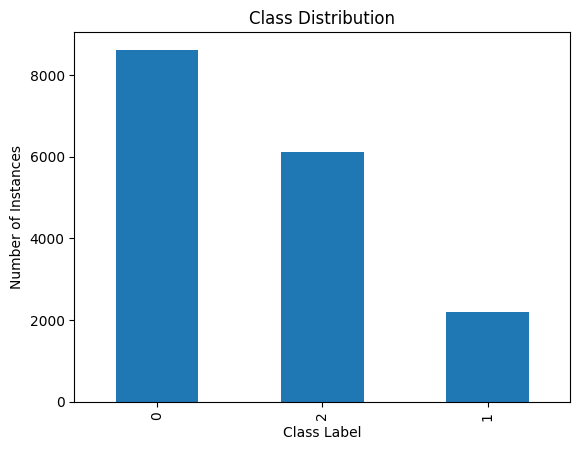

In [ ]:
# Display the distribution of the target variable in counts
class_distribution = ranges_mosq_Y.value_counts()
print("Class Distribution (Counts):")
print(class_distribution)

# Display the distribution of the target variable in percentages
class_distribution_percentage = ranges_mosq_Y.value_counts(normalize=True) * 100
print("\nClass Distribution (Percentage):")
print(class_distribution_percentage)

import matplotlib.pyplot as plt

class_distribution.plot(kind='bar', title='Class Distribution')
plt.ylabel('Number of Instances')
plt.xlabel('Class Label')
plt.show()

# Training ranges_csv


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

def evaluate_multiclass_model(model, X_test, y_test):
    if hasattr(model, 'predict_proba'):
        # If the model has predict_proba method, it's a probabilistic classifier
        y_prob = model.predict_proba(X_test)
    else:
        # Otherwise, use decision function for probabilistic score
        y_prob = model.decision_function(X_test)

    y_pred = model.predict(X_test)
    n_classes = len(np.unique(y_test))

    # Compute one-hot encoding for y_test and y_pred
    y_test_one_hot = label_binarize(y_test, classes=np.unique(y_test))
    y_pred_one_hot = label_binarize(y_pred, classes=np.unique(y_test))

    # Compute multiclass AUC-ROC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute macro-average ROC curve and AUC
    fpr_macro = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    tpr_macro = np.zeros_like(fpr_macro)
    for i in range(n_classes):
        tpr_macro += np.interp(fpr_macro, fpr[i], tpr[i])
    tpr_macro /= n_classes
    roc_auc_macro = auc(fpr_macro, tpr_macro)

    # Compute accuracy, F1-score, precision, recall, and confusion matrix
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    conf_matrix = confusion_matrix(y_test, y_pred)

    return {
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Precision': precision,
        'Recall': recall,
        'AUC ROC (Macro)': roc_auc_macro,
        'AUC ROC (Per Class)': roc_auc,
        'ROC Curve (Macro)': (fpr_macro, tpr_macro),
        'Confusion Matrix': conf_matrix
    }


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(ranges_mosq_X_pca, ranges_mosq_Y, test_size=0.30, random_state=42, stratify=ranges_mosq_Y)

In [ ]:
dt_params = {'max_depth': [4, 5, 6, 7, 8, 9, 10, 15,20,25], 'min_samples_leaf': [1, 2, 3, 4, 5,6,7,8,9,10], 'min_samples_split': list(range(2,10))}
dt_grid = GridSearchCV(DecisionTreeClassifier(), dt_params, cv=5, verbose = 10, n_jobs = -1)
dt_grid.fit(X_train, y_train)

Fitting 5 folds for each of 800 candidates, totalling 4000 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [4, 5, 6, 7, 8, 9, 10, 15, 20, 25],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9]},
             verbose=10)

In [ ]:
# KNN
knn_params = {'n_neighbors': [3, 5, 11, 19], 'weights': ['uniform', 'distance']}
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5)
knn_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 11, 19],
                         'weights': ['uniform', 'distance']})

In [ ]:
# Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
nb_scores = cross_val_score(nb_model, X_train, y_train, cv=5)

# Model evaluation for ranges_csv

In [ ]:
best_dt_model = dt_grid.best_estimator_
feature_importances = best_dt_model.feature_importances_
n_features = X_train.shape[1]
for i in range(n_features):
    print(f"Feature {i}: Importance: {feature_importances[i]}")

# # Additionally, you can access the feature importances for each tree in the grid search
# for i, tree in enumerate(dt_grid.best_estimator_.estimators_):
#     print(f"Tree {i+1} - Information Gain:")
#     for j in range(n_features):
#         print(f"  Feature {j}: Importance: {tree.feature_importances_[j]}")


Feature 0: Importance: 0.4756778747761618
Feature 1: Importance: 0.5243221252238383


In [ ]:
knn_best_params = knn_grid.best_params_
print(f"KNN best params: {knn_best_params}")
knn_evaluation = evaluate_multiclass_model(knn_grid.best_estimator_, X_test, y_test)
print("KNN Evaluation:", knn_evaluation)

KNN best params: {'n_neighbors': 19, 'weights': 'distance'}
KNN Evaluation: {'Accuracy': 0.6239669421487604, 'F1 Score': 0.5184714527230879, 'Precision': 0.521502382423195, 'Recall': 0.51695393651661, 'AUC ROC (Macro)': 0.7223593578008158, 'AUC ROC (Per Class)': {0: 0.7809356527639745, 1: 0.6080834506705308, 2: 0.7776695990178315}, 'ROC Curve (Macro)': (array([0.        , 0.01153846, 0.01176471, ..., 0.89026832, 0.89907889,
       1.        ]), array([0.        , 0.06169285, 0.06324807, ..., 0.96364572, 0.96602629,
       1.        ])), 'Confusion Matrix': array([[1933,  231,  421],
       [ 311,  133,  218],
       [ 519,  211, 1105]])}


In [ ]:
nb_best_params = nb_scores
print(f"Naive Bayes best params: {nb_best_params}")
nb_evaluation = evaluate_multiclass_model(nb_model, X_test, y_test)
print("Naive Bayes Evaluation:", nb_evaluation)

Naive Bayes best params: [0.5084317  0.5084317  0.50864614 0.50864614 0.50864614]
Naive Bayes Evaluation: {'Accuracy': 0.5086580086580087, 'F1 Score': 0.2247728359636538, 'Precision': 0.16955266955266957, 'Recall': 0.3333333333333333, 'AUC ROC (Macro)': 0.5079515488165715, 'AUC ROC (Per Class)': {0: 0.5123391396561754, 1: 0.49264620442646034, 2: 0.5184116295989842}, 'ROC Curve (Macro)': (array([0.00000000e+00, 2.26244344e-04, 3.07976594e-04, ...,
       9.99076070e-01, 9.99599519e-01, 1.00000000e+00]), array([0.00186361, 0.00186361, 0.00277188, ..., 0.9991736 , 0.99956045,
       1.        ])), 'Confusion Matrix': array([[2585,    0,    0],
       [ 662,    0,    0],
       [1835,    0,    0]])}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(f"Decision Tree best params: {dt_grid.best_params_}")
dt_evaluation_r= evaluate_multiclass_model(dt_grid.best_estimator_, X_test, y_test)
print("Decision Tree Evaluation:", dt_evaluation_r)

Decision Tree best params: {'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 2}
Decision Tree Evaluation: {'Accuracy': 0.5952380952380952, 'F1 Score': 0.48356518540774474, 'Precision': 0.4923358260530953, 'Recall': 0.48165359361221843, 'AUC ROC (Macro)': 0.6618638884177693, 'AUC ROC (Per Class)': {0: 0.7068494572597368, 1: 0.5780546404013616, 2: 0.7006797303568417}, 'ROC Curve (Macro)': (array([0.        , 0.06628959, 0.06696833, 0.06764706, 0.0719457 ,
       0.07239819, 0.07330317, 0.07466063, 0.10294118, 0.10384615,
       0.10520362, 0.10633484, 0.11085973, 0.11199095, 0.11515837,
       0.12811826, 0.12842624, 0.13058208, 0.13122172, 0.13181398,
       0.13484163, 0.13520172, 0.13574661, 0.13612565, 0.13704958,
       0.13766554, 0.13868778, 0.13920542, 0.14012935, 0.14049774,
       0.14502262, 0.14721281, 0.14844472, 0.15152448, 0.15214044,
       0.15520362, 0.15645211, 0.15953188, 0.16045581, 0.16137974,
       0.16153846, 0.17171946, 0.17511312, 0.17760181, 0.1782

In [ ]:
# Initialize set for unique hyperparameters
unique_hyperparameters = set()

# Initialize list for unique top models based on mean test score
unique_top_model_indices = []

# Set a threshold for minimum difference in performance to consider
performance_threshold = 0.0001  # e.g., 1% difference


# Get the results of the grid search
results = dt_grid.cv_results_

# Get the sorted scores and indices
sorted_indices = np.argsort(results['mean_test_score'])[::-1]
sorted_scores = results['mean_test_score'][sorted_indices]

# Loop over sorted scores and indices to find unique top models
# Loop over sorted scores and indices to find unique top models
for idx, score in zip(sorted_indices, sorted_scores):
    params = results['params'][idx]
    # Convert hyperparameters to a frozenset for uniqueness checking
    params_frozen = frozenset(params.items())
    # Check if this combination of hyperparameters is unique and differs from the next by the threshold
    if params_frozen not in unique_hyperparameters and \
       (len(unique_top_model_indices) == 0 or score <= sorted_scores[unique_top_model_indices[-1]] - performance_threshold):
        unique_hyperparameters.add(params_frozen)
        unique_top_model_indices.append(idx)
        # Break if we have found the desired number of unique models
        if len(unique_top_model_indices) >= 5:
            break


# Now unique_top_model_indices contains indices of unique models
# Continue with your plotting code using unique_top_model_indices


In [ ]:
# Print indices and hyperparameters
print("Indices of unique models:", unique_top_model_indices)
print("Hyperparameters of unique models:")
for idx in unique_top_model_indices:
    print(results['params'][idx])

Indices of unique models: [720, 16, 22, 20, 19]
Hyperparameters of unique models:
{'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 2}
{'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 2}
{'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 8}
{'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 6}
{'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 5}


In [ ]:
clf_initial = DecisionTreeClassifier(random_state=42)
clf_initial.fit(X_train, y_train)
y_pred_initial = clf_initial.predict(X_test)
print("Initial Model Performance:")
print(classification_report(y_test, y_pred_initial))

Initial Model Performance:
              precision    recall  f1-score   support

           0       0.70      0.74      0.72      2585
           1       0.23      0.23      0.23       662
           2       0.64      0.58      0.61      1835

    accuracy                           0.62      5082
   macro avg       0.52      0.52      0.52      5082
weighted avg       0.61      0.62      0.61      5082



In [ ]:
# Initialize set for unique hyperparameters
unique_hyperparameters = set()

# Initialize list for unique top models based on mean test score
unique_top_model_indices = []

# Set a threshold for minimum difference in performance to consider
performance_threshold = 0.0001  # e.g., 1% difference


# Get the results of the grid search
results = dt_grid.cv_results_

# Get the sorted scores and indices
sorted_indices = np.argsort(results['mean_test_score'])[::-1]
sorted_scores = results['mean_test_score'][sorted_indices]

# Loop over sorted scores and indices to find unique top models
# Loop over sorted scores and indices to find unique top models
for idx, score in zip(sorted_indices, sorted_scores):
    params = results['params'][idx]
    # Convert hyperparameters to a frozenset for uniqueness checking
    params_frozen = frozenset(params.items())
    # Check if this combination of hyperparameters is unique and differs from the next by the threshold
    if params_frozen not in unique_hyperparameters and \
       (len(unique_top_model_indices) == 0 or score <= sorted_scores[unique_top_model_indices[-1]] - performance_threshold):
        unique_hyperparameters.add(params_frozen)
        unique_top_model_indices.append(idx)
        # Break if we have found the desired number of unique models
        if len(unique_top_model_indices) >= 5:
            break


# Now unique_top_model_indices contains indices of unique models
# Continue with your plotting code using unique_top_model_indices


In [ ]:
dt_best_params_r = dt_grid.best_params_
print(f"Decision Tree best params: {dt_best_params_r}")
print("Decision Tree Evaluation:", dt_evaluation_r)

Decision Tree best params: {'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 2}
Decision Tree Evaluation: {'Accuracy': 0.5952380952380952, 'F1 Score': 0.48356518540774474, 'Precision': 0.4923358260530953, 'Recall': 0.48165359361221843, 'AUC ROC (Macro)': 0.6618638884177693, 'AUC ROC (Per Class)': {0: 0.7068494572597368, 1: 0.5780546404013616, 2: 0.7006797303568417}, 'ROC Curve (Macro)': (array([0.        , 0.06628959, 0.06696833, 0.06764706, 0.0719457 ,
       0.07239819, 0.07330317, 0.07466063, 0.10294118, 0.10384615,
       0.10520362, 0.10633484, 0.11085973, 0.11199095, 0.11515837,
       0.12811826, 0.12842624, 0.13058208, 0.13122172, 0.13181398,
       0.13484163, 0.13520172, 0.13574661, 0.13612565, 0.13704958,
       0.13766554, 0.13868778, 0.13920542, 0.14012935, 0.14049774,
       0.14502262, 0.14721281, 0.14844472, 0.15152448, 0.15214044,
       0.15520362, 0.15645211, 0.15953188, 0.16045581, 0.16137974,
       0.16153846, 0.17171946, 0.17511312, 0.17760181, 0.1782

Model 1 Metrics:
   F1 Score: 0.5855
   Testing Accuracy: 0.5964
   Training Accuracy: 0.8471
   Hyperparameters: {'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 2}
Model 2 Metrics:
   F1 Score: 0.3546
   Testing Accuracy: 0.5112
   Training Accuracy: 0.5140
   Hyperparameters: {'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 2}
Model 3 Metrics:
   F1 Score: 0.3546
   Testing Accuracy: 0.5112
   Training Accuracy: 0.5140
   Hyperparameters: {'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 8}
Model 4 Metrics:
   F1 Score: 0.3546
   Testing Accuracy: 0.5112
   Training Accuracy: 0.5140
   Hyperparameters: {'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 6}
Model 5 Metrics:
   F1 Score: 0.3546
   Testing Accuracy: 0.5112
   Training Accuracy: 0.5140
   Hyperparameters: {'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 5}


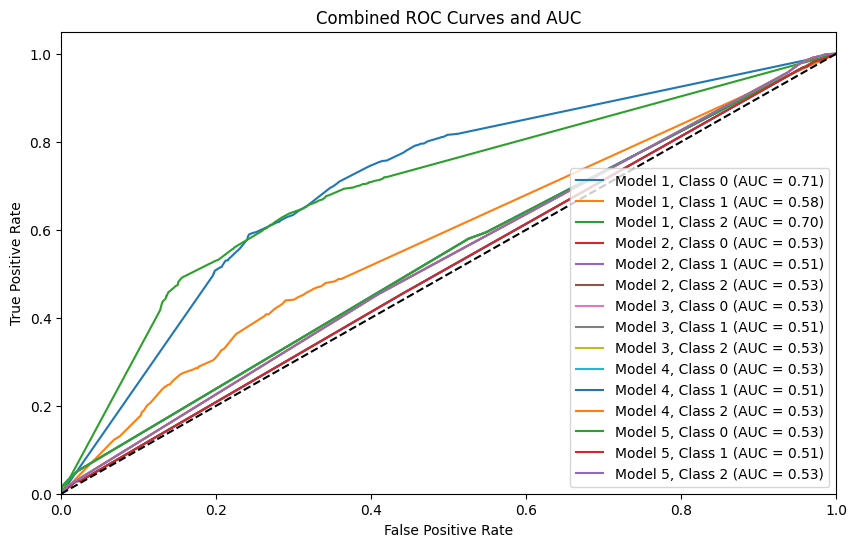

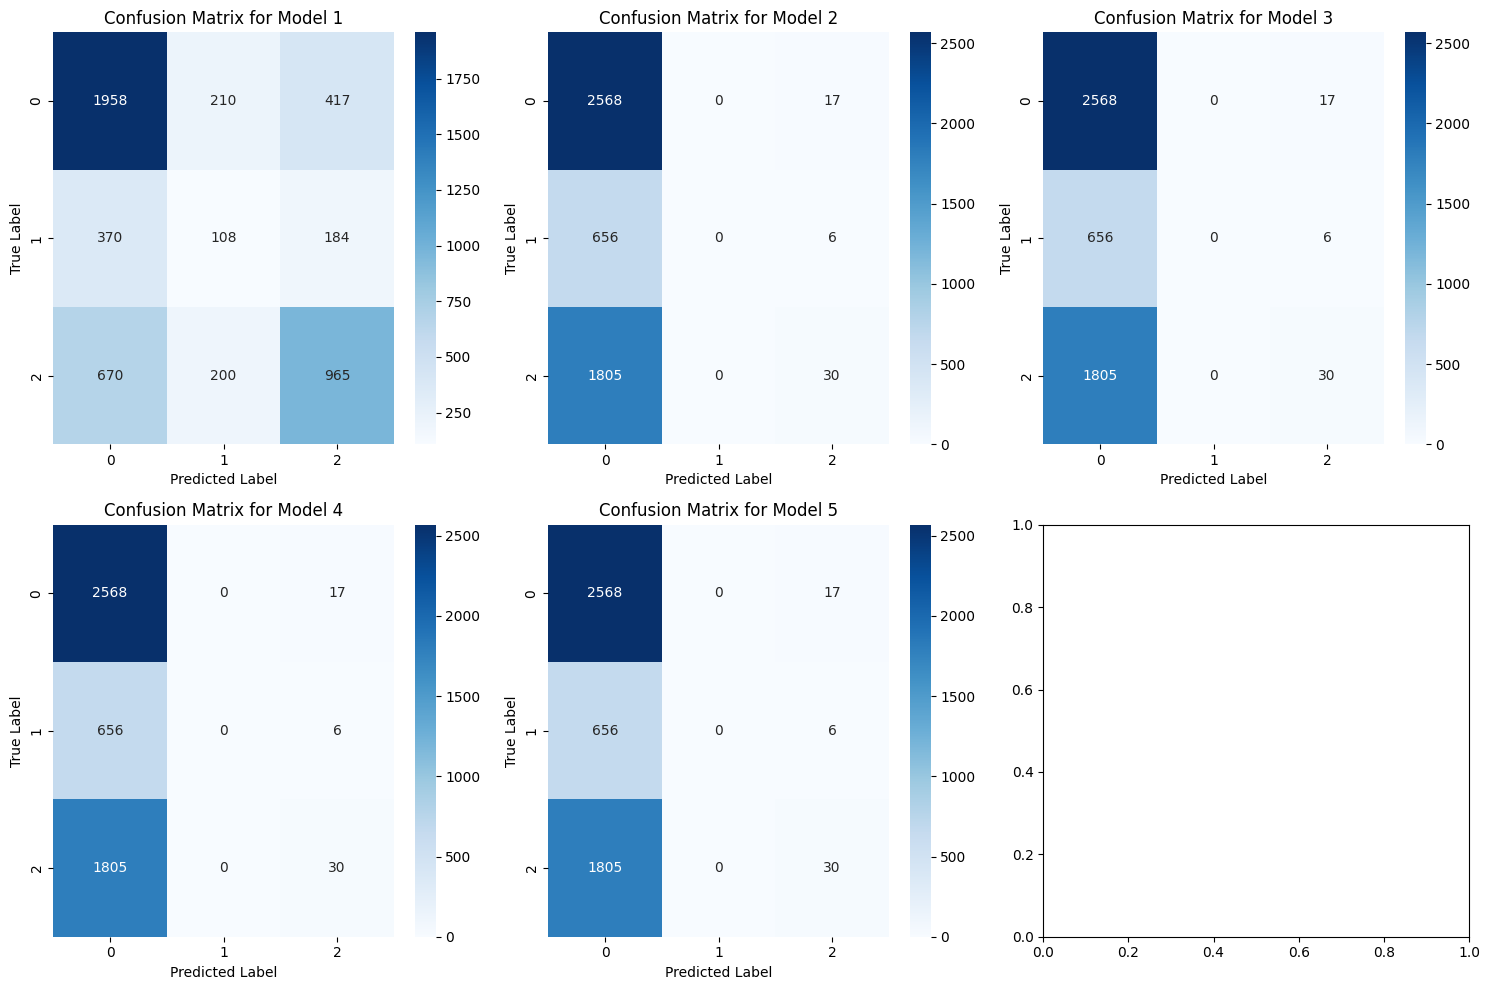

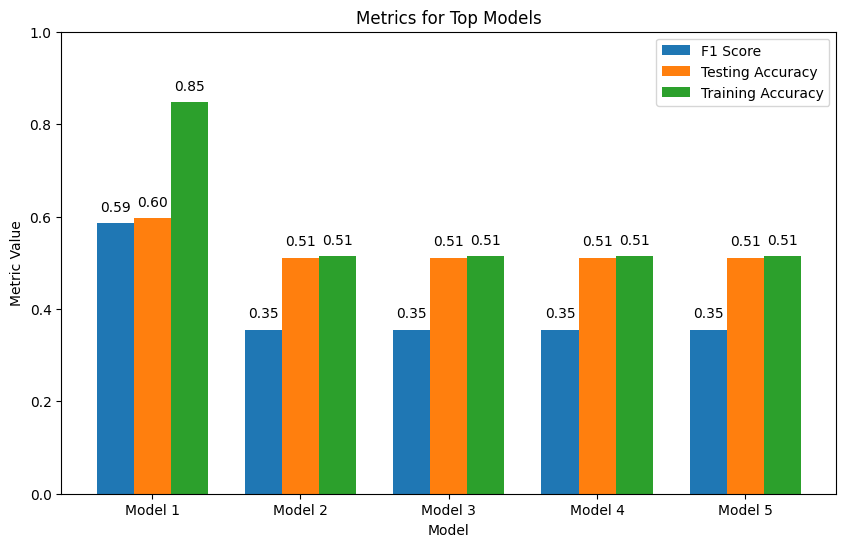

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Initialize subplots for ROC curve and AUC
fig_roc_auc, ax_roc_auc = plt.subplots(figsize=(10, 6))

# Initialize subplots for individual confusion matrices
fig_cm, axes_cm = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Initialize subplots for bar graph with F1 score, testing accuracy, and training accuracy
fig_metrics, ax_metrics = plt.subplots(figsize=(10, 6))

# Lists to store metrics
f1_scores, test_accuracies, train_accuracies = [], [], []

# Print hyperparameters for each model
for i, idx in enumerate(unique_top_model_indices):
    # Get the hyperparameters for the current model
    params = results['params'][idx]

    # Clone the model and set the parameters
    model = clone(dt_grid.best_estimator_).set_params(**params)
    model.fit(X_train, y_train)

    # Make predictions
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)

    # ROC Curve
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for class_idx in range(len(model.classes_)):
        fpr[class_idx], tpr[class_idx], _ = roc_curve(y_test == model.classes_[class_idx], y_test_proba[:, class_idx])
        roc_auc[class_idx] = auc(fpr[class_idx], tpr[class_idx])

    # Plotting individual ROC Curves
    for class_idx in range(len(model.classes_)):
        ax_roc_auc.plot(fpr[class_idx], tpr[class_idx], label=f'Model {i + 1}, Class {class_idx} (AUC = {roc_auc[class_idx]:.2f})')

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)

    # Plotting Confusion Matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes_cm[i//3, i%3])
    axes_cm[i//3, i%3].set_title(f"Confusion Matrix for Model {i + 1}")
    axes_cm[i//3, i%3].set_xlabel('Predicted Label')
    axes_cm[i//3, i%3].set_ylabel('True Label')

    # Calculate and store F1 score, testing accuracy, and training accuracy
    f1 = f1_score(y_test, y_test_pred, average='weighted')
    test_acc = accuracy_score(y_test, y_test_pred)
    train_acc = accuracy_score(y_train, model.predict(X_train))

    f1_scores.append(f1)
    test_accuracies.append(test_acc)
    train_accuracies.append(train_acc)

    # Print metrics and hyperparameters
    print(f"Model {i + 1} Metrics:")
    print(f"   F1 Score: {f1:.4f}")
    print(f"   Testing Accuracy: {test_acc:.4f}")
    print(f"   Training Accuracy: {train_acc:.4f}")
    print(f"   Hyperparameters: {params}")
    print("=" * 50)

# Adjust layout for ROC Curve and AUC
ax_roc_auc.plot([0, 1], [0, 1], 'k--')
ax_roc_auc.set_xlim([0.0, 1.0])
ax_roc_auc.set_ylim([0.0, 1.05])
ax_roc_auc.set_xlabel('False Positive Rate')
ax_roc_auc.set_ylabel('True Positive Rate')
ax_roc_auc.set_title('Combined ROC Curves and AUC')
ax_roc_auc.legend(loc="lower right")

# Adjust layout for Confusion Matrices
fig_cm.tight_layout()

# Bar graph with F1 score, testing accuracy, and training accuracy
models = [f'Model {i + 1}' for i in range(len(unique_top_model_indices))]
bar_width = 0.25
index = np.arange(len(models))

ax_metrics.bar(index, f1_scores, width=bar_width, label='F1 Score')
ax_metrics.bar(index + bar_width, test_accuracies, width=bar_width, label='Testing Accuracy')
ax_metrics.bar(index + 2 * bar_width, train_accuracies, width=bar_width, label='Training Accuracy')

# Add exact numbers on the bars
for i, value in enumerate(f1_scores):
    ax_metrics.text(i, value + 0.02, f'{value:.2f}', ha='center', va='bottom')
for i, value in enumerate(test_accuracies):
    ax_metrics.text(i + bar_width, value + 0.02, f'{value:.2f}', ha='center', va='bottom')
for i, value in enumerate(train_accuracies):
    ax_metrics.text(i + 2 * bar_width, value + 0.02, f'{value:.2f}', ha='center', va='bottom')

ax_metrics.set_xticks(index + bar_width)
ax_metrics.set_xticklabels(models)
ax_metrics.set_ylim([0, 1])
ax_metrics.set_xlabel('Model')
ax_metrics.set_ylabel('Metric Value')
ax_metrics.set_title('Metrics for Top Models')
ax_metrics.legend()

# Show all plots
plt.show()


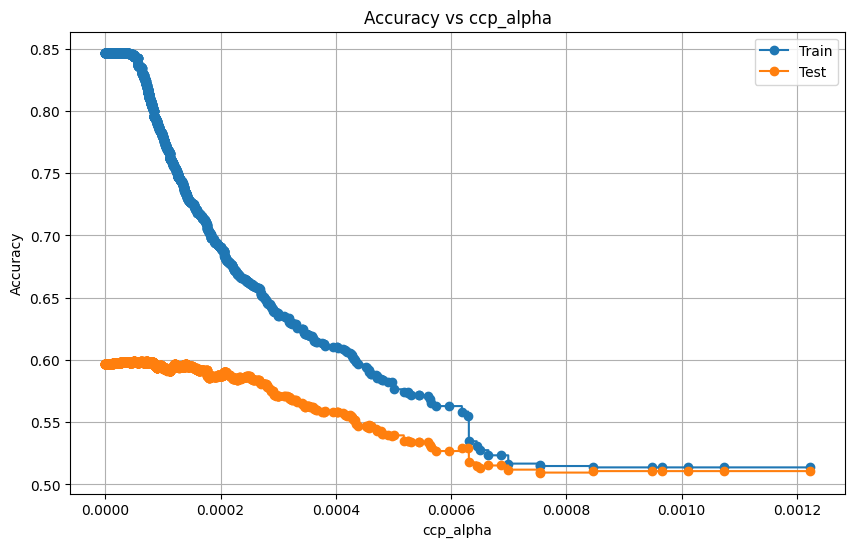

In [ ]:
# 3. Pruning using different ccp_alpha values
best_tree=dt_grid.best_estimator_
path = best_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
train_scores = []
test_scores = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha, **dt_grid.best_params_)
    clf.fit(X_train, y_train)
    train_scores.append(clf.score(X_train, y_train))
    test_scores.append(clf.score(X_test, y_test))

# Visualize the performance with different ccp_alpha values
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, train_scores, marker='o', label='Train', drawstyle="steps-post")
plt.plot(ccp_alphas, test_scores, marker='o', label='Test', drawstyle="steps-post")
plt.xlabel("ccp_alpha")
plt.ylabel("Accuracy")
plt.title("Accuracy vs ccp_alpha")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
optimal_ccp_alpha=0.0
clf_final = DecisionTreeClassifier(random_state=42, ccp_alpha=optimal_ccp_alpha, **dt_grid.best_params_)
clf_final.fit(X_train, y_train)
y_pred_final = clf_final.predict(X_test)

In [ ]:
print("Final Model Performance:")
print(classification_report(y_test, y_pred_final))

Final Model Performance:
              precision    recall  f1-score   support

           0       0.65      0.76      0.70      2585
           1       0.21      0.16      0.18       662
           2       0.62      0.52      0.57      1835

    accuracy                           0.60      5082
   macro avg       0.49      0.48      0.48      5082
weighted avg       0.58      0.60      0.59      5082



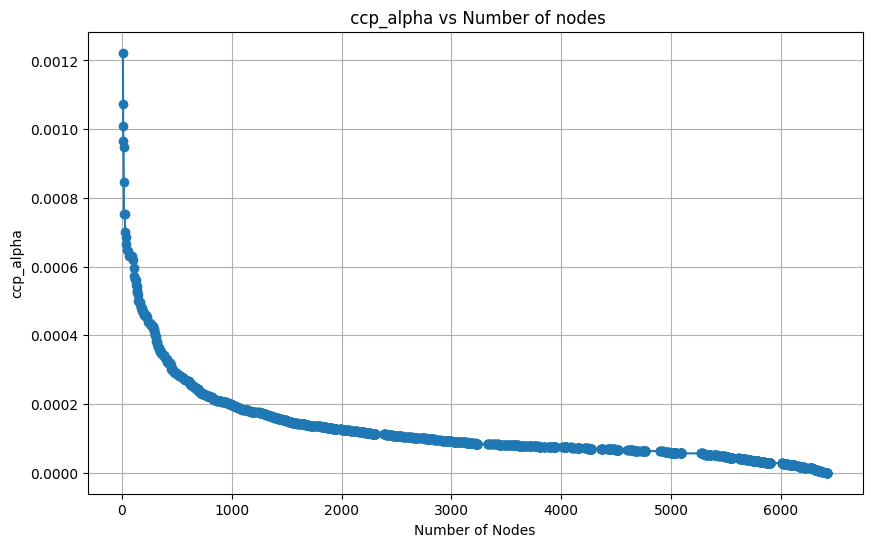

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

best_tree = dt_grid.best_estimator_
path = best_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
node_counts = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha, **dt_grid.best_params_)
    clf.fit(X_train, y_train)
    node_counts.append(clf.tree_.node_count)

# Visualize the relationship between number of nodes and ccp_alpha
plt.figure(figsize=(10, 6))
plt.plot(node_counts, ccp_alphas, marker='o', linestyle='-')
plt.xlabel("Number of Nodes")
plt.ylabel("ccp_alpha")
plt.title(" ccp_alpha vs Number of nodes")
plt.grid(True)
plt.show()


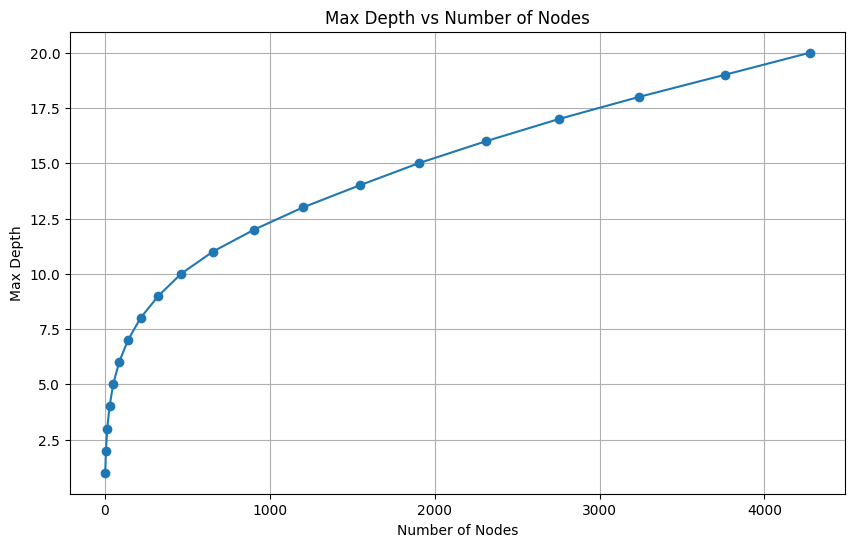

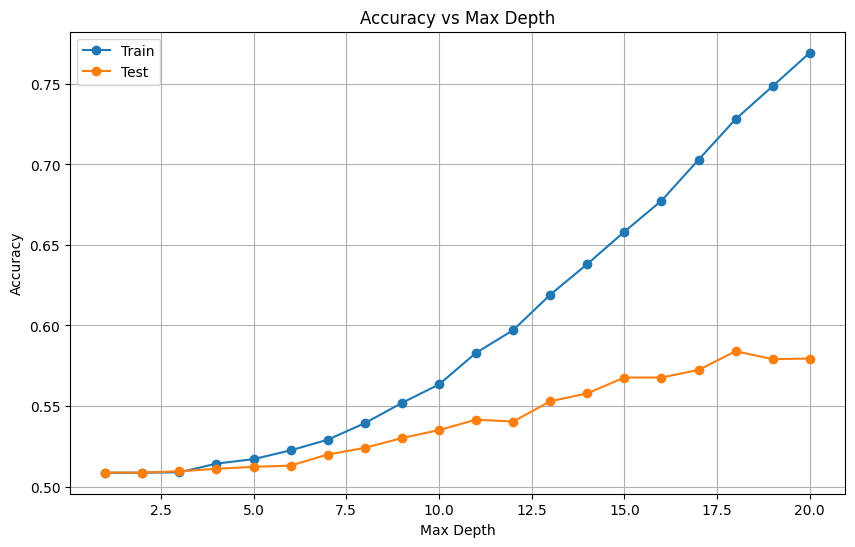

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

# Initialize lists to store values
max_depth_values = range(1, 21)  # Adjust range as needed
node_counts = []
train_accuracies = []
test_accuracies = []

# Calculate node counts and accuracies for different max_depth values
for depth in max_depth_values:
    clf = DecisionTreeClassifier(random_state=42, max_depth=depth)
    clf.fit(X_train, y_train)
    node_counts.append(clf.tree_.node_count)
    train_accuracies.append(clf.score(X_train, y_train))
    test_accuracies.append(clf.score(X_test, y_test))

# Plot max_depth vs number of nodes
plt.figure(figsize=(10, 6))
plt.plot(node_counts,max_depth_values, marker='o', linestyle='-')
plt.xlabel("Number of Nodes")
plt.ylabel("Max Depth")
plt.title("Max Depth vs Number of Nodes")
plt.grid(True)
plt.show()

# Plot accuracy vs max_depth
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, train_accuracies, marker='o', label='Train', linestyle='-')
plt.plot(max_depth_values, test_accuracies, marker='o', label='Test', linestyle='-')
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Max Depth")
plt.legend()
plt.grid(True)
plt.show()


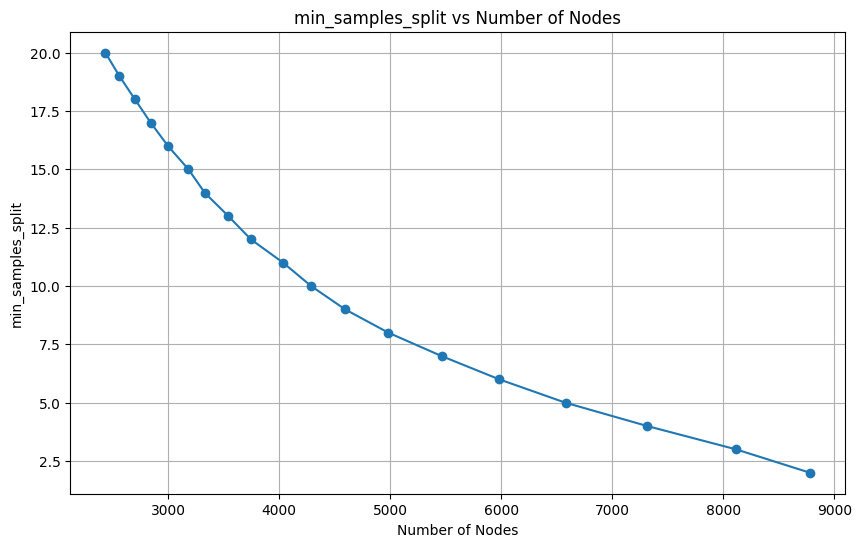

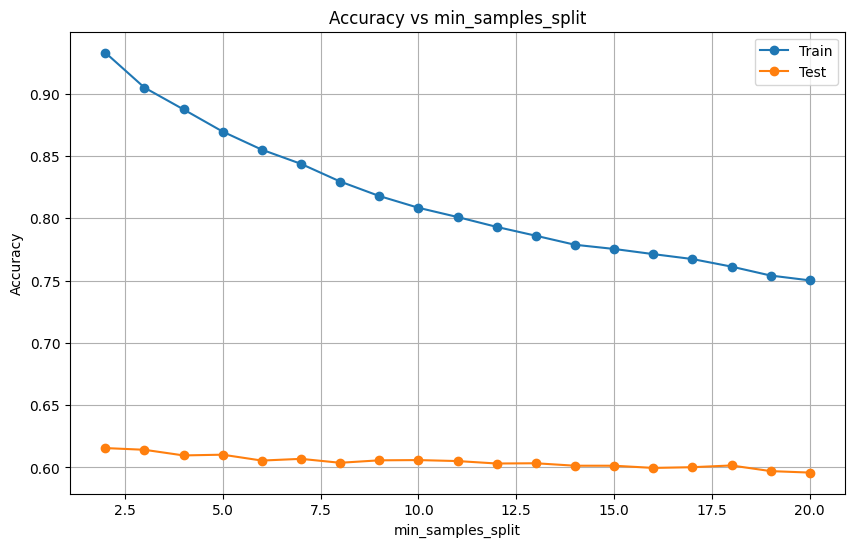

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

# Define min_samples_split values
min_samples_split_values = range(2, 21)  # Adjust range as needed

# Initialize lists to store values
node_counts = []
train_accuracies = []
test_accuracies = []

# Calculate node counts and accuracies for different min_samples_split values
for min_samples_split in min_samples_split_values:
    clf = DecisionTreeClassifier(random_state=42, min_samples_split=min_samples_split)
    clf.fit(X_train, y_train)
    node_counts.append(clf.tree_.node_count)
    train_accuracies.append(clf.score(X_train, y_train))
    test_accuracies.append(clf.score(X_test, y_test))

# Plot min_samples_split vs number of nodes
plt.figure(figsize=(10, 6))
plt.plot(node_counts,min_samples_split_values, marker='o', linestyle='-')
plt.xlabel("Number of Nodes")
plt.ylabel("min_samples_split")
plt.title("min_samples_split vs Number of Nodes")
plt.grid(True)
plt.show()

# Plot accuracy vs min_samples_split
plt.figure(figsize=(10, 6))
plt.plot(min_samples_split_values, train_accuracies, marker='o', label='Train', linestyle='-')
plt.plot(min_samples_split_values, test_accuracies, marker='o', label='Test', linestyle='-')
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.title("Accuracy vs min_samples_split")
plt.legend()
plt.grid(True)
plt.show()


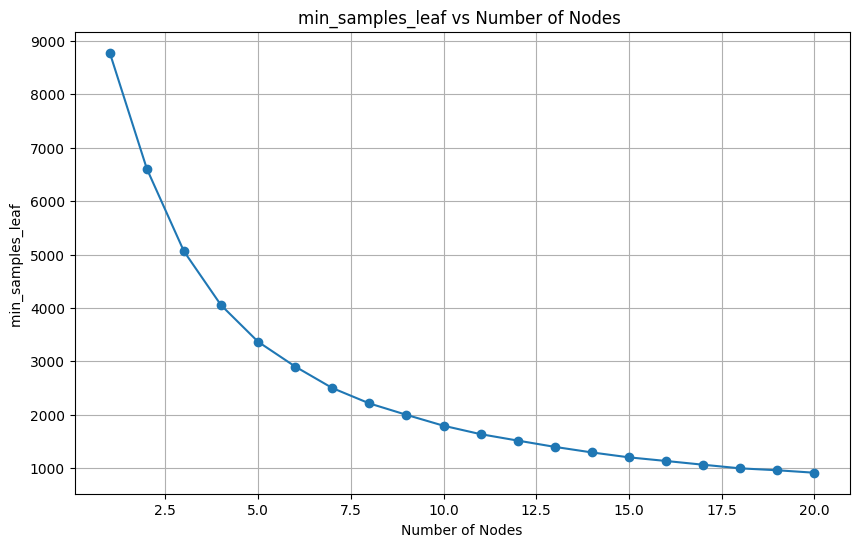

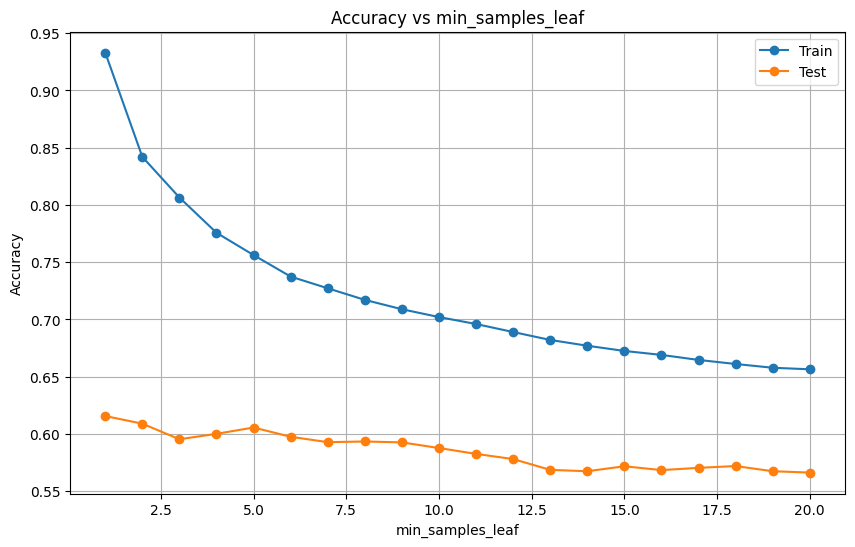

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

# Define min_samples_leaf values
min_samples_leaf_values = range(1, 21)  # Adjust range as needed

# Initialize lists to store values
node_counts = []
train_accuracies = []
test_accuracies = []

# Calculate node counts and accuracies for different min_samples_leaf values
for min_samples_leaf in min_samples_leaf_values:
    clf = DecisionTreeClassifier(random_state=42, min_samples_leaf=min_samples_leaf)
    clf.fit(X_train, y_train)
    node_counts.append(clf.tree_.node_count)
    train_accuracies.append(clf.score(X_train, y_train))
    test_accuracies.append(clf.score(X_test, y_test))

# Plot min_samples_leaf vs number of nodes
plt.figure(figsize=(10, 6))
plt.plot(min_samples_leaf_values, node_counts, marker='o', linestyle='-')
plt.xlabel("Number of Nodes")
plt.ylabel("min_samples_leaf ")
plt.title("min_samples_leaf vs Number of Nodes ")
plt.grid(True)
plt.show()

# Plot accuracy vs min_samples_leaf
plt.figure(figsize=(10, 6))
plt.plot(min_samples_leaf_values, train_accuracies, marker='o', label='Train', linestyle='-')
plt.plot(min_samples_leaf_values, test_accuracies, marker='o', label='Test', linestyle='-')
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.title("Accuracy vs min_samples_leaf")
plt.legend()
plt.grid(True)
plt.show()


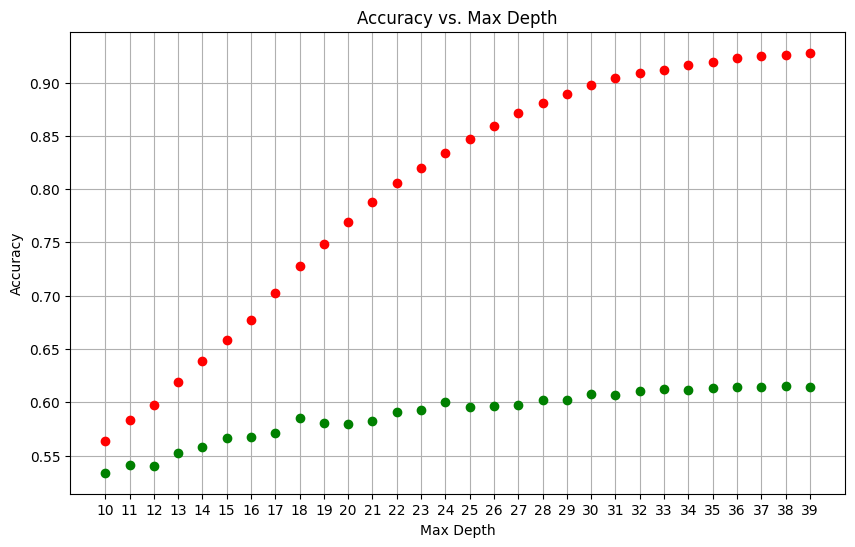

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

depths = []
test_accuracies = []
train_accuracies = []
max_depth_values = range(10,40)


for max_depth in max_depth_values:
    clf = DecisionTreeClassifier(max_depth=max_depth)
    clf.fit(X_train, y_train)
    # Predict on the test set
    y_pred = clf.predict(X_test)

    train_acc = clf.score(X_train, y_train)
    test_acc = clf.score(X_test, y_test)
    depths.append(max_depth)
    test_accuracies.append(test_acc)
    train_accuracies.append(train_acc)
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(depths, train_accuracies, 'ro')
plt.plot(depths, test_accuracies, 'go', )
plt.title('Accuracy vs. Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.xticks(depths)
plt.grid(True)
plt.show()

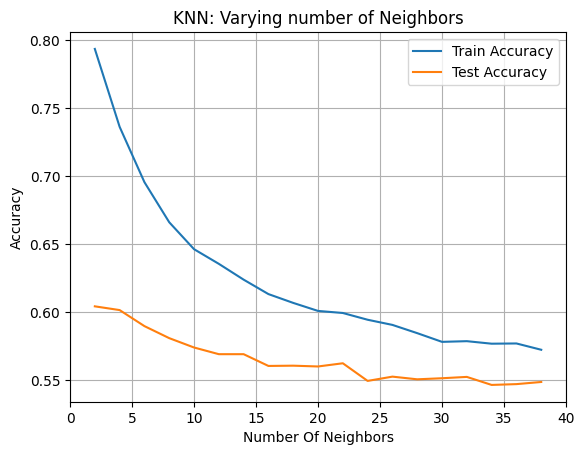

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
train_score = {}
test_score = {}
n_neighbors = np.arange(2, 40, 2)
for neighbor in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors=neighbor)
    knn.fit(X_train, y_train)
    train_score[neighbor]=knn.score(X_train, y_train)
    test_score[neighbor]=knn.score(X_test, y_test)
plt.plot(n_neighbors, train_score.values(), label="Train Accuracy")
plt.plot(n_neighbors, test_score.values(), label="Test Accuracy")
plt.xlabel("Number Of Neighbors")
plt.ylabel("Accuracy")
plt.title("KNN: Varying number of Neighbors")
plt.legend()
plt.xlim(0, 40)
# plt.ylim(0.70, 0.90)
plt.grid()
plt.show()

# Naive Bayes --- Final (ONLY STRATIFIED)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(ranges_mosq_X, ranges_mosq_Y, test_size=0.30, stratify=ranges_mosq_Y)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.naive_bayes import BernoulliNB

# Initialize the Bernoulli Naive Bayes classifier
clf = BernoulliNB()

# Train the classifier on the training set
clf.fit(X_train, y_train)

# Generate predictions on the testing set
y_pred_test = clf.predict(X_test)

# Generate the classification report
classification_report_test = classification_report(y_test, y_pred_test)

# Print the classification report
print("Classification Report on Testing Set:")
print(classification_report_test)

Classification Report on Testing Set:
              precision    recall  f1-score   support

           0       0.54      0.92      0.68      2585
           1       0.00      0.00      0.00       662
           2       0.55      0.20      0.29      1835

    accuracy                           0.54      5082
   macro avg       0.36      0.37      0.32      5082
weighted avg       0.47      0.54      0.45      5082



# Naive Bayes - PCA (ONLY STRATIFIED)

In [ ]:
# Applying PCA to reduce dimensionality while retaining 95% of the variance
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
ranges_mosq_X_pca = pca.fit_transform(ranges_mosq_X)

# The number of components chosen by PCA
n_components = pca.n_components_
print(f"PCA reduced the feature space to {n_components} components.")

# Get the selected components
selected_components = pca.components_

# Get the names of the original features
feature_names = ranges_mosq_X.columns

# Loop through each principal component to find the top features
for i, component in enumerate(selected_components):
    print(f"Top features for Principal Component {i+1}:")
    # Sort the indices of the features by their absolute coefficient values
    top_feature_indices = sorted(range(len(component)), key=lambda x: abs(component[x]), reverse=True)
    # Print the names of the top features
    for idx in top_feature_indices:
        print(f"{feature_names[idx]}: {component[idx]}")
    print()

PCA reduced the feature space to 2 components.
Top features for Principal Component 1:
SITE_NAME: 0.9847992506197008
ADMIN2: 0.1736963514472527
SPECIES: -8.632893984360148e-05
INSECTICIDE_CLASS: 4.423237116323725e-05
INSECTICIDE_TYPE: -4.204477151353579e-05
ADMIN1: 3.948137177320343e-05
COUNTRY_NAME: 2.4034901672687074e-05
INSECTICIDE_CONC: -1.2621899474570327e-05
MOSQUITO_NUMBER: -2.4919663548601803e-07
TEST_TYPE: 7.896710459979274e-08

Top features for Principal Component 2:
ADMIN2: -0.9847901621758828
SITE_NAME: 0.17369510765532034
ADMIN1: -0.0034765816532060234
SPECIES: 0.002211047518380603
COUNTRY_NAME: -0.0011610883958515015
INSECTICIDE_TYPE: -0.0001305460946937711
INSECTICIDE_CLASS: -7.408182075430148e-05
INSECTICIDE_CONC: -7.004883705704929e-06
MOSQUITO_NUMBER: 1.0815059587557765e-06
TEST_TYPE: -4.3042016403218886e-07



In [ ]:
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(ranges_mosq_X_pca, ranges_mosq_Y, test_size=0.30, stratify=ranges_mosq_Y)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

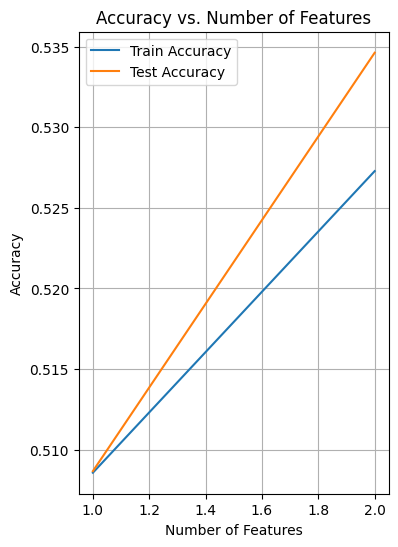

In [ ]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt

def compare_feature_selection(X_train, X_test, y_train, y_test, classifier):
    classifiers = {
        "BNB": BernoulliNB(),
    }

    max_features = range(1, X_train_p.shape[1] + 1)
    results = {classifier: {num_features: {"selected_features": None, "test": None, 'train': None, 'classification_report': None} for num_features in max_features} for classifier in classifiers}

    for num_features in max_features:
        for classifier_name, clf in classifiers.items():
            clf.fit(X_train.iloc[:, :num_features], y_train)
            train_acc = clf.score(X_train.iloc[:, :num_features], y_train)
            test_acc = clf.score(X_test.iloc[:, :num_features], y_test)
            results[classifier_name][num_features]["test"] = test_acc
            results[classifier_name][num_features]["train"] = train_acc
            # Get feature names
            selected_feature_names = X_train.columns[:num_features]
            results[classifier_name][num_features]["selected_features"] = selected_feature_names
            # Generate classification report
            y_pred = clf.predict(X_test.iloc[:, :num_features])
            report = classification_report(y_test, y_pred)
            results[classifier_name][num_features]["classification_report"] = report

    plt.figure(figsize=(4, 6))
    for classifier_name, data in results.items():
        test_accuracies = [data[num_features]["test"] for num_features in max_features]
        train_accuracies = [data[num_features]["train"] for num_features in max_features]
        plt.plot(list(max_features), train_accuracies, label='Train Accuracy')
        plt.plot(list(max_features), test_accuracies, label='Test Accuracy')

    plt.title('Accuracy vs. Number of Features')
    plt.xlabel('Number of Features')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    return results

results_pca = compare_feature_selection(X_train, X_test, y_train, y_test, "BNB")

In [ ]:
print(results_pca['BNB'][2]["classification_report"])

              precision    recall  f1-score   support

           0       0.53      0.92      0.68      2585
           1       0.00      0.00      0.00       662
           2       0.53      0.18      0.27      1835

    accuracy                           0.53      5082
   macro avg       0.36      0.37      0.32      5082
weighted avg       0.46      0.53      0.44      5082



# Naive Bayes - Feature Selection (ONLY STRATIFIED)

In [ ]:
from sklearn.feature_selection import mutual_info_classif
mi_scores = mutual_info_classif(X_train, y_train)

for i, score in enumerate(sorted(mi_scores, reverse = True)):
    print(f"Feature '{X_train.columns[i]}': Mutual Information Score = {score}")

Feature 'COUNTRY_NAME': Mutual Information Score = 0.18823789984216743
Feature 'INSECTICIDE_CLASS': Mutual Information Score = 0.18333852356281843
Feature 'ADMIN1': Mutual Information Score = 0.1748342411183783
Feature 'ADMIN2': Mutual Information Score = 0.12739831058393047
Feature 'SITE_NAME': Mutual Information Score = 0.09353588449346284
Feature 'INSECTICIDE_TYPE': Mutual Information Score = 0.041688397584935366
Feature 'INSECTICIDE_CONC': Mutual Information Score = 0.03830319575123409
Feature 'MOSQUITO_NUMBER': Mutual Information Score = 0.030598234494316534
Feature 'SPECIES': Mutual Information Score = 0.02245873013559474
Feature 'TEST_TYPE': Mutual Information Score = 0.0


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators = 250, random_state=42)
rf_classifier.fit(X_train, y_train)

feature_importances = rf_classifier.feature_importances_

feature_importance_dict = {feature: importance for feature, importance in zip(X_train.columns, feature_importances)}

sorted_feature_importance = {k: v for k, v in sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)}

print(sorted_feature_importance)
print(list(sorted_feature_importance.keys()))

{'SITE_NAME': 0.17015589712039256, 'MOSQUITO_NUMBER': 0.15165982417821378, 'COUNTRY_NAME': 0.14665185241694711, 'SPECIES': 0.1347328838673682, 'ADMIN2': 0.13387393359072142, 'ADMIN1': 0.1274234293005849, 'INSECTICIDE_TYPE': 0.05445897948869148, 'INSECTICIDE_CONC': 0.043217939295719106, 'INSECTICIDE_CLASS': 0.037825260741361444, 'TEST_TYPE': 0.0}
['SITE_NAME', 'MOSQUITO_NUMBER', 'COUNTRY_NAME', 'SPECIES', 'ADMIN2', 'ADMIN1', 'INSECTICIDE_TYPE', 'INSECTICIDE_CONC', 'INSECTICIDE_CLASS', 'TEST_TYPE']


In [ ]:
RF_importance = list(sorted_feature_importance.keys())
mi_scores_list = [X_train.columns[i] for i, _ in enumerate(sorted(mi_scores, reverse = True))]
print(RF_importance)
print(mi_scores_list)

['SITE_NAME', 'MOSQUITO_NUMBER', 'COUNTRY_NAME', 'SPECIES', 'ADMIN2', 'ADMIN1', 'INSECTICIDE_TYPE', 'INSECTICIDE_CONC', 'INSECTICIDE_CLASS', 'TEST_TYPE']
['COUNTRY_NAME', 'INSECTICIDE_CLASS', 'ADMIN1', 'ADMIN2', 'SITE_NAME', 'INSECTICIDE_TYPE', 'INSECTICIDE_CONC', 'MOSQUITO_NUMBER', 'SPECIES', 'TEST_TYPE']


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

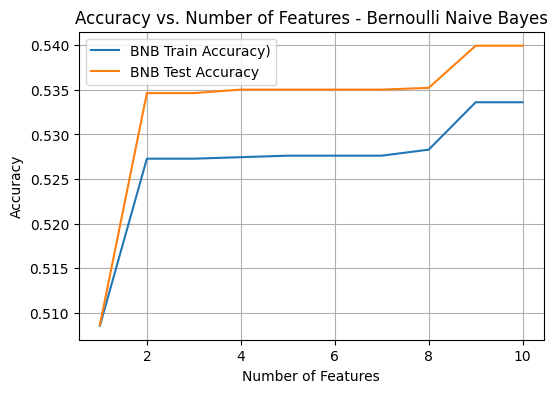

In [ ]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import matplotlib.pyplot as plt

def compare_feature_selection(X_train, X_test, y_train, y_test, mi_scores_list):
    classifiers = {
        "BNB": BernoulliNB(),
    }

    max_features = range(1, len(mi_scores_list) + 1)
    results = {num_features: {classifier_name: {'classification_report': '', 'train_acc': [], 'test_acc': []} for classifier_name in classifiers} for num_features in max_features}

    for num_features in max_features:
        for classifier_name, classifier in classifiers.items():
            selected_features = mi_scores_list[:num_features]
            X_train_selected = X_train[selected_features]
            X_test_selected = X_test[selected_features]

            classifier.fit(X_train_selected, y_train)
            train_acc = classifier.score(X_train_selected, y_train)
            test_acc = classifier.score(X_test_selected, y_test)
            results[num_features][classifier_name]['train_acc'].append(train_acc)
            results[num_features][classifier_name]['test_acc'].append(test_acc)

            y_pred = classifier.predict(X_test_selected)
            report = classification_report(y_test, y_pred)
            results[num_features][classifier_name]['classification_report'] = report

    # Plotting
    plt.figure(figsize=(6, 4))
    for classifier_name in classifiers:
        train_accs = [results[num_features][classifier_name]['train_acc'][-1] for num_features in max_features]
        test_accs = [results[num_features][classifier_name]['test_acc'][-1] for num_features in max_features]
        plt.plot(max_features, train_accs, label=f'{classifier_name} Train Accuracy)')
        plt.plot(max_features, test_accs, label=f'{classifier_name} Test Accuracy')

    plt.title('Accuracy vs. Number of Features - Bernoulli Naive Bayes')
    plt.xlabel('Number of Features')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    return results

results_mi = compare_feature_selection(X_train, X_test, y_train, y_test, mi_scores_list)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

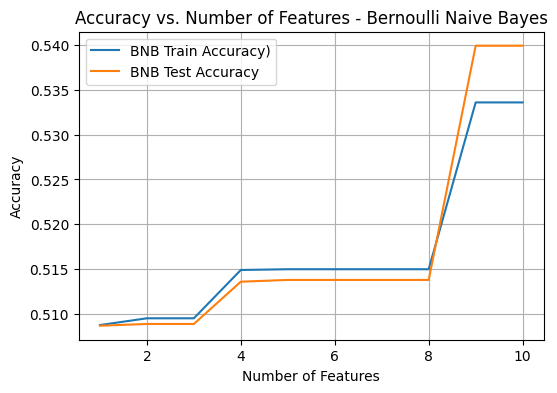

In [ ]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import matplotlib.pyplot as plt

def compare_feature_selection(X_train, X_test, y_train, y_test, RF_importance):
    classifiers = {
        "BNB": BernoulliNB(),
    }

    max_features = range(1, len(RF_importance) + 1)
    results = {num_features: {classifier_name: {'classification_report': '', 'train_acc': [], 'test_acc': []} for classifier_name in classifiers} for num_features in max_features}

    for num_features in max_features:
        for classifier_name, classifier in classifiers.items():
            selected_features = RF_importance[:num_features]
            X_train_selected = X_train[selected_features]
            X_test_selected = X_test[selected_features]

            classifier.fit(X_train_selected, y_train)
            train_acc = classifier.score(X_train_selected, y_train)
            test_acc = classifier.score(X_test_selected, y_test)
            results[num_features][classifier_name]['train_acc'].append(train_acc)
            results[num_features][classifier_name]['test_acc'].append(test_acc)

            y_pred = classifier.predict(X_test_selected)
            report = classification_report(y_test, y_pred)
            results[num_features][classifier_name]['classification_report'] = report

    # Plotting
    plt.figure(figsize=(6, 4))
    for classifier_name in classifiers:
        train_accs = [results[num_features][classifier_name]['train_acc'][-1] for num_features in max_features]
        test_accs = [results[num_features][classifier_name]['test_acc'][-1] for num_features in max_features]
        plt.plot(max_features, train_accs, label=f'{classifier_name} Train Accuracy)')
        plt.plot(max_features, test_accs, label=f'{classifier_name} Test Accuracy')

    plt.title('Accuracy vs. Number of Features - Bernoulli Naive Bayes')
    plt.xlabel('Number of Features')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    return results

results_mi = compare_feature_selection(X_train, X_test, y_train, y_test, RF_importance)

# Naive Bayes --- Final (OVERSAMPLING, UNDERSAMPLING AND STRATIFIED)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(ranges_mosq_X, ranges_mosq_Y, test_size=0.30, stratify=ranges_mosq_Y)

In [33]:
from sklearn.metrics import classification_report
from sklearn.naive_bayes import BernoulliNB

# Initialize the Bernoulli Naive Bayes classifier
clf = BernoulliNB()

# Train the classifier on the training set
clf.fit(X_train, y_train)

# Generate predictions on the testing set
y_pred_test = clf.predict(X_test)

# Generate the classification report
classification_report_test = classification_report(y_test, y_pred_test)

# Print the classification report
print("Classification Report on Testing Set:")
print(classification_report_test)

Classification Report on Testing Set:
              precision    recall  f1-score   support

           0       0.40      0.44      0.42      1836
           1       0.37      0.55      0.44      1835
           2       0.49      0.20      0.28      1836

    accuracy                           0.40      5507
   macro avg       0.42      0.40      0.38      5507
weighted avg       0.42      0.40      0.38      5507



# Naive Bayes - PCA (OVERSAMPLING, UNDERSAMPLING AND STRATIFIED)

In [53]:
# Applying PCA to reduce dimensionality while retaining 95% of the variance
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
ranges_mosq_X_pca = pca.fit_transform(ranges_mosq_X)

# The number of components chosen by PCA
n_components = pca.n_components_
print(f"PCA reduced the feature space to {n_components} components.")

# Get the selected components
selected_components = pca.components_

# Get the names of the original features
feature_names = ranges_mosq_X.columns

# Loop through each principal component to find the top features
for i, component in enumerate(selected_components):
    print(f"Top features for Principal Component {i+1}:")
    # Sort the indices of the features by their absolute coefficient values
    top_feature_indices = sorted(range(len(component)), key=lambda x: abs(component[x]), reverse=True)
    # Print the names of the top features
    for idx in top_feature_indices:
        print(f"{feature_names[idx]}: {component[idx]}")
    print()

PCA reduced the feature space to 2 components.
Top features for Principal Component 1:
SITE_NAME: 0.9867397011614909
ADMIN2: 0.1623105903330429
SPECIES: -0.00016408903735264796
INSECTICIDE_CLASS: 6.106932261433495e-05
COUNTRY_NAME: -4.774311132828995e-05
INSECTICIDE_TYPE: -3.482104740169193e-05
INSECTICIDE_CONC: -1.5175931752499391e-05
ADMIN1: 6.356268027030154e-06
MOSQUITO_NUMBER: -4.181748073807399e-07
TEST_TYPE: 5.711112770822627e-09

Top features for Principal Component 2:
ADMIN2: -0.9866744905365987
SITE_NAME: 0.16230028887531944
ADMIN1: -0.011233813926285197
SPECIES: 0.002325576590793764
COUNTRY_NAME: -0.0006587664073698672
INSECTICIDE_TYPE: -0.00014817945274475902
INSECTICIDE_CLASS: -5.4434834296956947e-05
INSECTICIDE_CONC: -1.3348936322974281e-05
MOSQUITO_NUMBER: 1.3238874861624955e-06
TEST_TYPE: -3.057554091017524e-07



In [54]:
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(ranges_mosq_X_pca, ranges_mosq_Y, test_size=0.30, stratify=ranges_mosq_Y)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

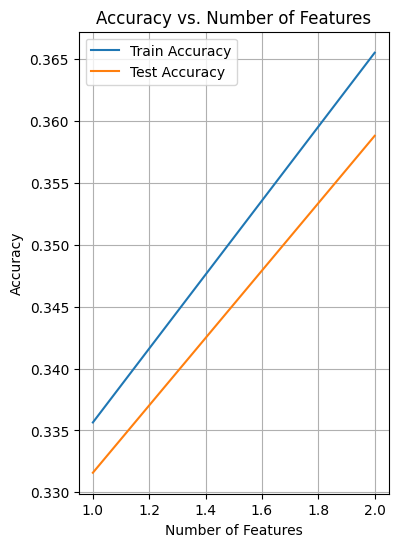

In [55]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt

def compare_feature_selection(X_train, X_test, y_train, y_test, classifier):
    classifiers = {
        "BNB": BernoulliNB(),
    }

    max_features = range(1, X_train_p.shape[1] + 1)
    results = {classifier: {num_features: {"selected_features": None, "test": None, 'train': None, 'classification_report': None} for num_features in max_features} for classifier in classifiers}

    for num_features in max_features:
        for classifier_name, clf in classifiers.items():
            clf.fit(X_train.iloc[:, :num_features], y_train)
            train_acc = clf.score(X_train.iloc[:, :num_features], y_train)
            test_acc = clf.score(X_test.iloc[:, :num_features], y_test)
            results[classifier_name][num_features]["test"] = test_acc
            results[classifier_name][num_features]["train"] = train_acc
            # Get feature names
            selected_feature_names = X_train.columns[:num_features]
            results[classifier_name][num_features]["selected_features"] = selected_feature_names
            # Generate classification report
            y_pred = clf.predict(X_test.iloc[:, :num_features])
            report = classification_report(y_test, y_pred)
            results[classifier_name][num_features]["classification_report"] = report

    plt.figure(figsize=(4, 6))
    for classifier_name, data in results.items():
        test_accuracies = [data[num_features]["test"] for num_features in max_features]
        train_accuracies = [data[num_features]["train"] for num_features in max_features]
        plt.plot(list(max_features), train_accuracies, label='Train Accuracy')
        plt.plot(list(max_features), test_accuracies, label='Test Accuracy')

    plt.title('Accuracy vs. Number of Features')
    plt.xlabel('Number of Features')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    return results

results_pca = compare_feature_selection(X_train, X_test, y_train, y_test, "BNB")

In [56]:
print(results_pca['BNB'][2]["classification_report"])

              precision    recall  f1-score   support

           0       0.35      0.90      0.50      1836
           1       0.00      0.00      0.00      1835
           2       0.43      0.18      0.25      1836

    accuracy                           0.36      5507
   macro avg       0.26      0.36      0.25      5507
weighted avg       0.26      0.36      0.25      5507



# Naive Bayes - Feature Selection (OVERSAMPLING, UNDERSAMPLING AND STRATIFIED)

In [57]:
from sklearn.feature_selection import mutual_info_classif
mi_scores = mutual_info_classif(X_train, y_train)

for i, score in enumerate(sorted(mi_scores, reverse = True)):
    print(f"Feature '{X_train.columns[i]}': Mutual Information Score = {score}")

Feature 'COUNTRY_NAME': Mutual Information Score = 0.21270999181675854
Feature 'INSECTICIDE_CLASS': Mutual Information Score = 0.19226684102157665
Feature 'ADMIN1': Mutual Information Score = 0.19160708101088608
Feature 'ADMIN2': Mutual Information Score = 0.18842837081191655
Feature 'SITE_NAME': Mutual Information Score = 0.1697778651950983
Feature 'INSECTICIDE_TYPE': Mutual Information Score = 0.12603375274625805
Feature 'INSECTICIDE_CONC': Mutual Information Score = 0.12185076433879027
Feature 'MOSQUITO_NUMBER': Mutual Information Score = 0.0570987682213655
Feature 'SPECIES': Mutual Information Score = 0.014749464965139403
Feature 'TEST_TYPE': Mutual Information Score = 0.007993260755052578


In [58]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators = 250, random_state=42)
rf_classifier.fit(X_train, y_train)

feature_importances = rf_classifier.feature_importances_

feature_importance_dict = {feature: importance for feature, importance in zip(X_train.columns, feature_importances)}

sorted_feature_importance = {k: v for k, v in sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)}

print(sorted_feature_importance)
print(list(sorted_feature_importance.keys()))

{'SITE_NAME': 0.15670441612396976, 'MOSQUITO_NUMBER': 0.14054666336604213, 'COUNTRY_NAME': 0.12844227061479088, 'ADMIN2': 0.1259235041626933, 'SPECIES': 0.120742171317723, 'ADMIN1': 0.1185497538368896, 'INSECTICIDE_CONC': 0.10465800770922988, 'INSECTICIDE_TYPE': 0.06781918488346983, 'INSECTICIDE_CLASS': 0.0365299251094797, 'TEST_TYPE': 8.410287571193828e-05}
['SITE_NAME', 'MOSQUITO_NUMBER', 'COUNTRY_NAME', 'ADMIN2', 'SPECIES', 'ADMIN1', 'INSECTICIDE_CONC', 'INSECTICIDE_TYPE', 'INSECTICIDE_CLASS', 'TEST_TYPE']


In [59]:
RF_importance = list(sorted_feature_importance.keys())
mi_scores_list = [X_train.columns[i] for i, _ in enumerate(sorted(mi_scores, reverse = True))]
print(RF_importance)
print(mi_scores_list)

['SITE_NAME', 'MOSQUITO_NUMBER', 'COUNTRY_NAME', 'ADMIN2', 'SPECIES', 'ADMIN1', 'INSECTICIDE_CONC', 'INSECTICIDE_TYPE', 'INSECTICIDE_CLASS', 'TEST_TYPE']
['COUNTRY_NAME', 'INSECTICIDE_CLASS', 'ADMIN1', 'ADMIN2', 'SITE_NAME', 'INSECTICIDE_TYPE', 'INSECTICIDE_CONC', 'MOSQUITO_NUMBER', 'SPECIES', 'TEST_TYPE']


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

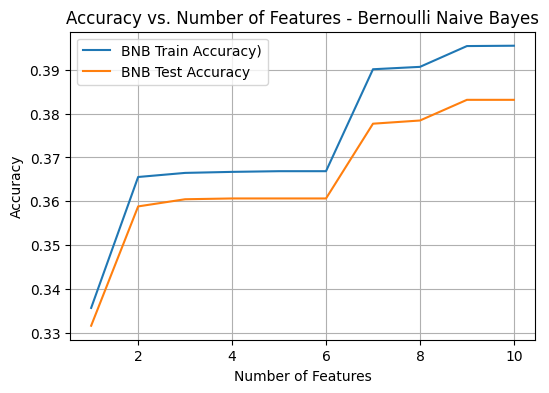

In [62]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import matplotlib.pyplot as plt

def compare_feature_selection(X_train, X_test, y_train, y_test, mi_scores_list):
    classifiers = {
        "BNB": BernoulliNB(),
    }

    max_features = range(1, len(mi_scores_list) + 1)
    results = {num_features: {classifier_name: {'classification_report': '', 'train_acc': [], 'test_acc': []} for classifier_name in classifiers} for num_features in max_features}

    for num_features in max_features:
        for classifier_name, classifier in classifiers.items():
            selected_features = mi_scores_list[:num_features]
            X_train_selected = X_train[selected_features]
            X_test_selected = X_test[selected_features]

            classifier.fit(X_train_selected, y_train)
            train_acc = classifier.score(X_train_selected, y_train)
            test_acc = classifier.score(X_test_selected, y_test)
            results[num_features][classifier_name]['train_acc'].append(train_acc)
            results[num_features][classifier_name]['test_acc'].append(test_acc)

            y_pred = classifier.predict(X_test_selected)
            report = classification_report(y_test, y_pred)
            results[num_features][classifier_name]['classification_report'] = report

    # Plotting
    plt.figure(figsize=(6, 4))
    for classifier_name in classifiers:
        train_accs = [results[num_features][classifier_name]['train_acc'][-1] for num_features in max_features]
        test_accs = [results[num_features][classifier_name]['test_acc'][-1] for num_features in max_features]
        plt.plot(max_features, train_accs, label=f'{classifier_name} Train Accuracy)')
        plt.plot(max_features, test_accs, label=f'{classifier_name} Test Accuracy')

    plt.title('Accuracy vs. Number of Features - Bernoulli Naive Bayes')
    plt.xlabel('Number of Features')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    return results

results_mi = compare_feature_selection(X_train, X_test, y_train, y_test, mi_scores_list)

In [65]:
print(results_mi[7]['BNB']['classification_report'])

              precision    recall  f1-score   support

           0       0.37      0.42      0.40      1836
           1       0.37      0.53      0.43      1835
           2       0.43      0.18      0.25      1836

    accuracy                           0.38      5507
   macro avg       0.39      0.38      0.36      5507
weighted avg       0.39      0.38      0.36      5507



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

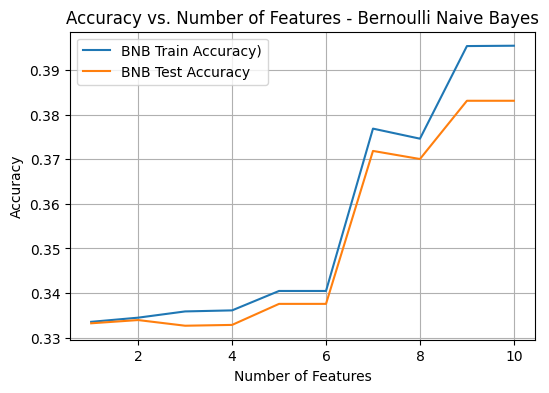

In [68]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import matplotlib.pyplot as plt

def compare_feature_selection(X_train, X_test, y_train, y_test, RF_importance):
    classifiers = {
        "BNB": BernoulliNB(),
    }

    max_features = range(1, len(RF_importance) + 1)
    results = {num_features: {classifier_name: {'classification_report': '', 'train_acc': [], 'test_acc': []} for classifier_name in classifiers} for num_features in max_features}

    for num_features in max_features:
        for classifier_name, classifier in classifiers.items():
            selected_features = RF_importance[:num_features]
            X_train_selected = X_train[selected_features]
            X_test_selected = X_test[selected_features]

            classifier.fit(X_train_selected, y_train)
            train_acc = classifier.score(X_train_selected, y_train)
            test_acc = classifier.score(X_test_selected, y_test)
            results[num_features][classifier_name]['train_acc'].append(train_acc)
            results[num_features][classifier_name]['test_acc'].append(test_acc)

            y_pred = classifier.predict(X_test_selected)
            report = classification_report(y_test, y_pred)
            results[num_features][classifier_name]['classification_report'] = report

    # Plotting
    plt.figure(figsize=(6, 4))
    for classifier_name in classifiers:
        train_accs = [results[num_features][classifier_name]['train_acc'][-1] for num_features in max_features]
        test_accs = [results[num_features][classifier_name]['test_acc'][-1] for num_features in max_features]
        plt.plot(max_features, train_accs, label=f'{classifier_name} Train Accuracy)')
        plt.plot(max_features, test_accs, label=f'{classifier_name} Test Accuracy')

    plt.title('Accuracy vs. Number of Features - Bernoulli Naive Bayes')
    plt.xlabel('Number of Features')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    return results

results_rf = compare_feature_selection(X_train, X_test, y_train, y_test, RF_importance)

In [69]:
print(results_rf[7]['BNB']['classification_report'])

              precision    recall  f1-score   support

           0       0.38      0.43      0.40      1836
           1       0.36      0.67      0.47      1835
           2       0.85      0.02      0.04      1836

    accuracy                           0.37      5507
   macro avg       0.53      0.37      0.30      5507
weighted avg       0.53      0.37      0.30      5507

